In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from scipy.stats import entropy

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, brier_score_loss
from sklearn.tree import plot_tree
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from skpsl import ProbabilisticScoringList
from skpsl.preprocessing import MinEntropyBinarizer
from xgboost import XGBClassifier

In [2]:
folder = Path("experiments/data/liver_disorders")
# folder = Path("data/liver_disorders")

data_bupa = pd.read_csv(folder/"bupa.data", sep=",", header=None, names = ["mcv",
"alkphos",
"sgpt",
"sgot",
"gammagt",
"drinks",
"selector"])

data_bupa["drinks"] = (data_bupa["drinks"] >= 3).astype("int")

costs_bupa = pd.read_csv(folder/"bupa-liver.expense", sep=r"\t+", header = None, index_col=0, engine="python")
costs_bupa[1] = costs_bupa[1].str.strip(",").astype(float)
costs_bupa.index = costs_bupa.index.str.strip(":")
costs_bupa

,1,2
0,,
mcv,7.27,5.17
alkphos,7.27,5.17
sgpt,7.27,5.17
sgot,7.27,5.17
gammagt,9.86,7.76


In [3]:
folder = Path("experiments/data/thyroid")
# folder = Path("data/thyroid")

names = ["age",
"sex",
"on_thyroxine",
"query_on_thyroxine",
"on_antithyroid_medication",
"sick",
"pregnant",
"thyroid_surgery",
"I131_treatment",
"query_hypothyroid",
"query_hyperthyroid",
"lithium",
"goitre",
"tumor",
"hypopituitary",
"psych",
"TSH",
"T3",
"TT4",
"T4U","FTI","class"]

# df = pd.read_csv("experiments/data/thyroid/ann-train.data", sep=" ", header=None)
data_thyroid_train = pd.read_csv(folder/"ann-train.data", sep="\\ ", header=None, names=names)
data_thyroid_test = pd.read_csv(folder/"ann-test.data", sep="\\ ", header=None, names=names)

print(len(data_thyroid_train)+len(data_thyroid_test))

# remove hypothyroid patients
data_thyroid_train = data_thyroid_train[data_thyroid_train["class"] > 1]
data_thyroid_test = data_thyroid_test[data_thyroid_test["class"] > 1] 

print(len(data_thyroid_train)+len(data_thyroid_test))

# drop FTI as in original paper by Turney
data_thyroid_train = data_thyroid_train.drop(columns="FTI")
data_thyroid_test = data_thyroid_test.drop(columns="FTI")

X_train_thyroid, y_train_thyroid = data_thyroid_train.iloc[:,:-1].to_numpy(), data_thyroid_train.iloc[:,-1].to_numpy()
X_test_thyroid, y_test_thyroid = data_thyroid_test.iloc[:,:-1].to_numpy(), data_thyroid_test.iloc[:,-1].to_numpy()

# convert y to 0,1 where 0 is normal and 1 hyperthyroid
y_train_thyroid, y_test_thyroid = 1 - (y_train_thyroid -2), 1 - (y_test_thyroid - 2)

# X = np.concatenate((X_train, X_test), axis=0)
# y = np.concatenate((y_train, y_test), axis=0)

# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=1/3)

7200
7034


/tmp/ipykernel_32224/4264196764.py:26: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data_thyroid_train = pd.read_csv(folder/"ann-train.data", sep="\\ ", header=None, names=names)
/tmp/ipykernel_32224/4264196764.py:27: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data_thyroid_test = pd.read_csv(folder/"ann-test.data", sep="\\ ", header=None, names=names)


In [4]:
data_bupa_train = data_bupa[data_bupa.selector==2].drop(columns="selector")
data_bupa_test = data_bupa[data_bupa.selector==1].drop(columns="selector")
print(len(data_bupa_train),len(data_bupa_test))

200 145


In [5]:
costs_thyroid = pd.read_csv("experiments/data/thyroid/ann-thyroid.expense", sep=r"\t+", header = None, index_col=0, engine="python")
costs_thyroid[1] = costs_thyroid[1].str.strip(",").astype(float)

In [6]:
X_train_bupa, y_train_bupa = data_bupa_train.iloc[:,:-1].to_numpy(), data_bupa_train.iloc[:,-1].to_numpy() 
X_test_bupa, y_test_bupa = data_bupa_test.iloc[:,:-1].to_numpy(), data_bupa_test.iloc[:,-1].to_numpy()


In [7]:

pre_psl_bupa = MinEntropyBinarizer(method="brute")
psl_bupa = ProbabilisticScoringList(score_set={-3,-2,-1,1,2,3})
psl_pipe_bupa = make_pipeline(pre_psl_bupa, psl_bupa)

pre_dt_bupa = MinEntropyBinarizer(method="brute")
# dt_bupa = DecisionTreeClassifier(criterion="entropy", max_depth=None)
dt_bupa = DecisionTreeClassifier(criterion="entropy")
dt_pipe_bupa = make_pipeline(pre_dt_bupa, dt_bupa)

psl_pipe_bupa.fit(X_train_bupa, y_train_bupa)
dt_pipe_bupa.fit(X_train_bupa, y_train_bupa)

psl_bupa = psl_pipe_bupa[-1]
dt_bupa = dt_pipe_bupa[-1]

pre_bupa = psl_pipe_bupa[:-1]

X_test_bupa = pre_bupa.transform(X_test_bupa)

In [8]:

pre_psl_thyroid = MinEntropyBinarizer(method="brute")
psl_thyroid = ProbabilisticScoringList(score_set={-3,-2,-1,1,2,3})
psl_pipe_thyroid = make_pipeline(pre_psl_thyroid, psl_thyroid)

pre_dt_thyroid = MinEntropyBinarizer(method="brute")
# dt_thyroid = DecisionTreeClassifier(criterion="entropy", max_depth=None)
dt_thyroid = DecisionTreeClassifier(criterion="entropy")
dt_pipe_thyroid = make_pipeline(pre_dt_thyroid, dt_thyroid)

psl_pipe_thyroid.fit(X_train_thyroid, y_train_thyroid)
dt_pipe_thyroid.fit(X_train_thyroid, y_train_thyroid)

psl_thyroid = psl_pipe_thyroid[-1]
dt_thyroid = dt_pipe_thyroid[-1]

pre_thyroid = psl_pipe_thyroid[:-1]

X_test_thyroid = pre_thyroid.transform(X_test_thyroid)

In [9]:
def get_bupa_cost_for_feature_subset(subset):
    cost = 0.0
    unique_values, indices = np.unique(subset, return_index=True)
    unique_in_order = unique_values[np.argsort(indices)]
    if unique_in_order.size >= 0.0:
        for i,s in enumerate(unique_in_order):
            if i == 0:
                cost += costs_bupa.iloc[s,0]
            else:
                cost += costs_bupa.iloc[s,1]
        return cost
    else:
        raise TypeError("Alarm")
    

def get_thyroid_cost_for_feature_subset(subset):
    cost = 0.0
    unique_values, indices = np.unique(subset, return_index=True)
    unique_in_order = unique_values[np.argsort(indices)]
    group_a = [16,17,18,19]
    if unique_in_order.size >= 0.0:
        for i,s in enumerate(unique_in_order):
            discount = False
            if s in group_a:
                if discount:
                    cost += float(costs_thyroid.iloc[s,1])
                else:
                    cost += float(costs_thyroid.iloc[s,0])
            else:
                cost += 1
        return cost
    else:
        raise TypeError("Alarm")

# def predict_with_cost(dt, X_test, dataset):
#     y_probas = []
#     features_pred = []
#     cost_pred = []

#     for x_test in X_test:
#         x_test = x_test.reshape(1,-1)
#         y_proba = dt.predict_proba(x_test)
#         y_probas.append(y_proba)

#         # Get the decision path for the test instance
#         decision_path = dt.decision_path(x_test)

#         # Get feature indices used at each node
#         node_indicator = decision_path.indices
#         features_used = dt.tree_.feature[node_indicator]

#         # Filter out any -2s, which represent leaf nodes
#         features_used = features_used[features_used != -2]
        
#         features_pred.append(features_used)
#         if dataset=="bupa":
#             cost_summand = get_bupa_cost_for_feature_subset(features_used)
#         elif dataset=="thyroid":
#             cost_summand = get_bupa_cost_for_feature_subset(features_used)
#         else:
#             raise NotImplementedError("This dataset is not implemented yet!")
#         cost_pred.append(cost_summand)
#     return np.asarray(y_proba), cost_pred, features_pred 

In [10]:
def limited_feature_predict(clf, X, max_features):
    """
    Make predictions by limiting the number of features the tree can make.
    
    Parameters:
    clf: Trained decision tree classifier
    X: Feature matrix
    max_splits: Maximum number of features to traverse before making a prediction
    
    Returns:
    predictions: Array of predictions for each sample in X
    """
    tree = clf.tree_
    n_samples = X.shape[0]
    predictions = []
   
    feature_lists = []

    for i in range(n_samples):
        feature_list = []
        node_id = 0  # Start at the root node

        while tree.children_left[node_id] != tree.children_right[node_id]:  # While not a leaf
            # Get the feature to split on and the threshold to compare to
            feature = tree.feature[node_id]

            # Stop if the max number of splits is reached
            if len(set(feature_list + [feature])) > max_features:
                break
            
            feature_list.append(feature)
            threshold = tree.threshold[node_id]

            # Traverse to the left or right child based on feature value
            if X[i, feature] <= threshold:
                node_id = tree.children_left[node_id]
            else:
                node_id = tree.children_right[node_id]

        # After the loop, we are at a node, make a prediction
        # Use the majority class of this node to make a prediction
        predictions.append(tree.value[node_id]) 
        feature_lists.append(feature_list)

    return np.vstack(predictions), feature_lists

def psl_limited_feature_predict(psl, X, max_features):
    predictions = []   
    feature_lists = []

    for row in X:
        p, k = None,None
        for k in range(max_features+1):
            p = psl[k].predict_proba([row])
            if entropy(p.squeeze(),base=2) == 0:
                break
        predictions.append(p)
        feature_lists.append(psl.features[:k])

    return np.vstack(predictions), feature_lists

In [11]:
def evaluate(dataset):
    briers_psl = []
    briers_dt = []

    accs_psl = []
    accs_dt = []

    baccs_psl = []
    baccs_dt = []

    costs_psl = []
    costs_dt = []

    if dataset=="bupa":
        X_test = X_test_bupa
        y_test = y_test_bupa
        psl = psl_bupa
        dt = dt_bupa
        cost_fnc = get_bupa_cost_for_feature_subset
    elif dataset=="thyroid":
        X_test = X_test_thyroid
        y_test = y_test_thyroid
        psl = psl_thyroid
        dt = dt_thyroid
        cost_fnc = get_thyroid_cost_for_feature_subset
    else:
        raise NotImplementedError("This dataset is not implemented yet!")

    num_features = X_test.shape[1]
 
    for i in range(0,num_features):
        y_prob_psl = psl.predict_proba(X_test, k=i)

        y_prob_psl, used_features_psl = psl_limited_feature_predict(psl, X_test, max_features=i)
        psl_cost = sum(map(cost_fnc,used_features_psl))

        y_prob_dt, used_features = limited_feature_predict(dt, X_test, max_features=i)
        dt_cost = sum(map(cost_fnc,used_features))

        briers_psl.append(brier_score_loss(y_test, y_prob_psl[:,1]))
        briers_dt.append(brier_score_loss(y_test, y_prob_dt[:,1]))

        accs_psl.append(accuracy_score(y_test, np.argmax(y_prob_psl,axis=1)))
        accs_dt.append(accuracy_score(y_test, np.argmax(y_prob_dt,axis=1)))

        baccs_psl.append(balanced_accuracy_score(y_test, np.argmax(y_prob_psl,axis=1)))
        baccs_dt.append(balanced_accuracy_score(y_test, np.argmax(y_prob_dt,axis=1)))

        costs_psl.append(psl_cost)
        costs_dt.append(dt_cost)
    return briers_psl, briers_dt, accs_psl, accs_dt, baccs_psl, baccs_dt, costs_psl, costs_dt

In [12]:

briers_psl_bupa, briers_dt_bupa, accs_psl_bupa, accs_dt_bupa, baccs_psl_bupa, baccs_dt_bupa, costs_psl_bupa, costs_dt_bupa = results_bupa = evaluate("bupa")
briers_psl_thyroid, briers_dt_thyroid, accs_psl_thyroid, accs_dt_thyroid, baccs_psl_thyroid, baccs_dt_thyroid, costs_psl_thyroid, costs_dt_thyroid = results_thyroid = evaluate("thyroid")

df_1 = pd.DataFrame( {"method":["psl"]*len(briers_psl_bupa), "dataset": ["bupa"]*len(briers_psl_bupa), "cost":costs_psl_bupa, "brier":briers_psl_bupa,"acc":accs_psl_bupa,"bacc":baccs_psl_bupa})
df_2 = pd.DataFrame({"method":["dt"]*len(briers_dt_bupa), "dataset": ["bupa"]*len(briers_dt_bupa), "cost":costs_dt_bupa, "brier":briers_dt_bupa,"acc":accs_dt_bupa,"bacc":baccs_dt_bupa})
df_3 = pd.DataFrame({"method":["psl"]*len(briers_psl_thyroid), "dataset": ["thyroid"]*len(briers_psl_thyroid), "cost":costs_psl_thyroid, "brier":briers_psl_thyroid,"acc":accs_psl_thyroid,"bacc":baccs_psl_thyroid})
df_4 = pd.DataFrame({"method":["dt"]*len(briers_dt_thyroid), "dataset": ["thyroid"]*len(briers_dt_thyroid), "cost":costs_dt_thyroid, "brier":briers_dt_thyroid,"acc":accs_dt_thyroid,"bacc":baccs_dt_thyroid})

df = pd.concat([df_1,df_2,df_3,df_4])

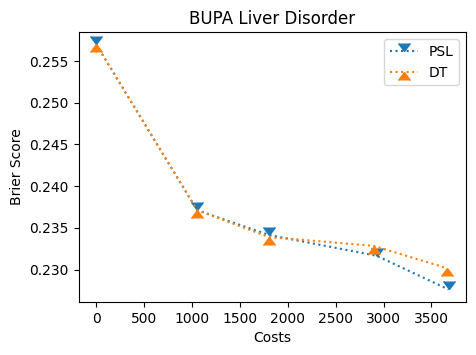

In [13]:
plt.figure(figsize=(5,3.5))
plt.plot(costs_psl_bupa, briers_psl_bupa, label="PSL", marker=7, ls=":", markersize=8)
plt.plot(costs_dt_bupa, briers_dt_bupa, label="DT", marker=6, ls=":", markersize=8)

plt.xlabel("Costs")
plt.ylabel("Brier Score")

plt.legend()
plt.title("BUPA Liver Disorder")
plt.savefig("brier_psl_dt_bupa.pdf")
plt.show()

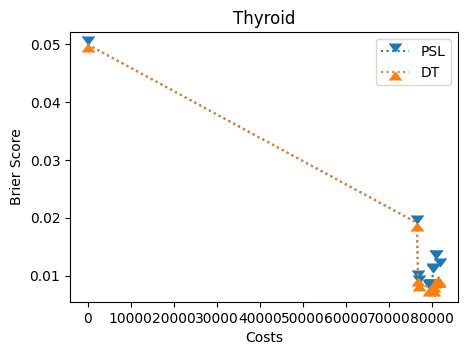

In [14]:
plt.figure(figsize=(5,3.5))
plt.plot(costs_psl_thyroid, briers_psl_thyroid, label="PSL", marker=7, ls=":", markersize=8)
plt.plot(costs_dt_thyroid, briers_dt_thyroid, label="DT", marker=6, ls=":", markersize=8)

plt.xlabel("Costs")
plt.ylabel("Brier Score")

plt.legend()
plt.title("Thyroid")
plt.savefig("brier_psl_dt_thyroid.pdf")
plt.show()

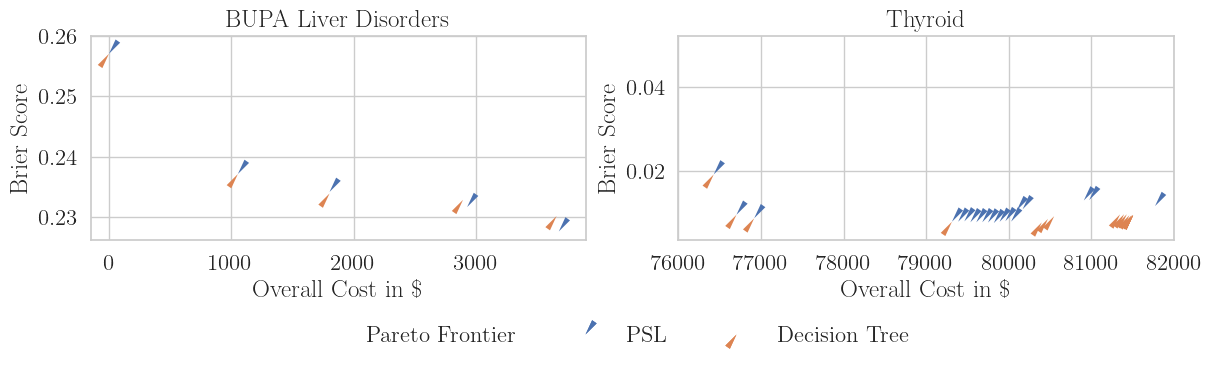

In [42]:
from matplotlib.markers import MarkerStyle
from matplotlib.transforms import Affine2D
from matplotlib.path import Path

sns.set(font_scale=1.5,rc={'text.usetex' : True})
sns.set_style("whitegrid")
plt.rc('font', **{'family': 'serif'})
plt.rcParams["figure.figsize"] = (12, 3)

def pareto_frontier(X, Y):
    # Sort points by X, and then by Y descending
    sorted_points = sorted(zip(X, Y), key=lambda x: (x[0], x[1]))
    pareto_x = []
    pareto_y = []
    current_min_y = np.inf
    
    for x, y in sorted_points:
        if y < current_min_y:
            pareto_x.append(x)
            pareto_y.append(y)
            current_min_y = y
    return pareto_x, pareto_y


fig,axes = plt.subplots(1,2, sharey=False, layout='constrained')
axes = axes.ravel()
hue_order = ["psl", "dt"]

# df_ = pd.DataFrame(data=[], columns=["method","costs","brier","acc","bacc"])

names = {"bupa" : "BUPA Liver Disorders", "thyroid": "Thyroid", "psl":"PSL", "dt":"Decision Tree", "pareto": "Pareto Frontier"}

# markers=[MarkerStyle("$'$","left",Affine2D().translate(0.25,.60).rotate_deg((i)*180)) for i in range(2)]

# markers = {"psl": "1", "dt": "2"}

markers=[MarkerStyle(Path([(0, 0), (1, -.18), (1, .18), (0, 0)], [Path.MOVETO, Path.LINETO, Path.LINETO, Path.CLOSEPOLY]),transform=Affine2D().rotate_deg(i*180+55)) for i in range(2)]


#markers=["1" ]
linestyles = {'psl': (2,2), 'dt': (2,2),'pareto': (2,2)}

for i, dataset in enumerate(["bupa", "thyroid"]):
    df_ = df[df.dataset==dataset]
    ax = axes[i]
    pareto_x, pareto_y = pareto_frontier(df_.cost, df_.brier)
    pareto_y.append(pareto_y[-1])
    pareto_x.append(999999999)
    #print(df_)
    # sns.lineplot(df_,  x="cost", y="brier", hue="method", dashes=linestyles, style ="method", ax=ax, drawstyle="steps-post")
    sns.lineplot(x=pareto_x, y=pareto_y, label="pareto", color="black", ax=ax,drawstyle="steps-post",linestyle="-", lw=0.5, zorder=1)
    ax.get_legend().remove()
    # sns.scatterplot(df_, x="cost", y="brier", hue="method", markers=markers,  style ="method", s=250, lw=2, ax=ax)
    sns.scatterplot(df_, x="cost", y="brier", hue="method", markers=markers,  style ="method", s=500, lw=0, ax=ax,zorder=2)
    # pareto_y.insert(0,pareto_y[0])
    # pareto_x.insert(0,pareto_y[1])
    # Plot Pareto frontier as a step plot
    ax.get_legend().remove()
    ax.set_title(names[dataset])
    ax.set_ylabel("Brier Score")
    ax.set_xlabel(r"Overall Cost in \$")
    if i==1:
        ax.set_xlim((76000,82000))
        ax.set_ylim((0.0035,None))
    if i==0:
        ax.set_xlim((-150,3900))
        ax.set_ylim((None,0.26))

handles, labels = ax.get_legend_handles_labels()
labels = [names[label] for label in labels]
# lgd = fig.legend(list(zip(handles[:2],handles[2:])), labels[2:], loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0), frameon=False)
lgd = fig.legend(list(zip(handles,handles)), labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0), frameon=False)

plt.savefig("costs_pareto.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')
    # ax.set_xticks(list(range(0,11)))
# ax.xaxis.set_major_locator(MaxNLocator(integer=True))

In [16]:
df.columns

Index(['method', 'dataset', 'cost', 'brier', 'acc', 'bacc'], dtype='object')

In [17]:
df.dataset

0        bupa
1        bupa
2        bupa
3        bupa
4        bupa
0        bupa
1        bupa
2        bupa
3        bupa
4        bupa
0     thyroid
1     thyroid
2     thyroid
3     thyroid
4     thyroid
5     thyroid
6     thyroid
7     thyroid
8     thyroid
9     thyroid
10    thyroid
11    thyroid
12    thyroid
13    thyroid
14    thyroid
15    thyroid
16    thyroid
17    thyroid
18    thyroid
19    thyroid
0     thyroid
1     thyroid
2     thyroid
3     thyroid
4     thyroid
5     thyroid
6     thyroid
7     thyroid
8     thyroid
9     thyroid
10    thyroid
11    thyroid
12    thyroid
13    thyroid
14    thyroid
15    thyroid
16    thyroid
17    thyroid
18    thyroid
19    thyroid
Name: dataset, dtype: object

In [18]:
psl_thyroid.inspect()

,Stage,Feature Index,Score,T = -25,T = -24,T = -23,T = -22,T = -21,T = -20,T = -19,...,T = -1,T = 0,T = 1,T = 2,T = 3,T = 4,T = 5,T = 6,T = 7,T = 8
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.051916,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,16.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000000,NaN,NaN,0.707407,NaN,NaN,NaN,NaN,NaN
2,2,2.0,-3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000000,NaN,NaN,0.884259,NaN,NaN,NaN,NaN,NaN
3,3,7.0,-3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000000,NaN,NaN,0.927184,NaN,NaN,NaN,NaN,NaN
4,4,17.0,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000000,0.838710,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
5,5,6.0,-3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000000,0.838710,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
6,6,8.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.838710,1.0,1.000000,NaN,NaN,NaN,NaN,NaN
7,7,12.0,-3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.838710,1.0,1.000000,NaN,NaN,NaN,NaN,NaN
8,8,14.0,-3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.838710,1.0,1.000000,NaN,NaN,NaN,NaN,NaN
9,9,0.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,0.000000,0.827957,1.000000,1.0,1.000000,NaN,NaN,NaN,NaN,NaN


In [19]:
def evaluate_insample(dataset):
    briers_psl = []
    briers_dt = []

    accs_psl = []
    accs_dt = []

    baccs_psl = []
    baccs_dt = []

    costs_psl = []
    costs_dt = []

    if dataset=="bupa":
        X_test = pre_bupa.transform(X_train_bupa) 
        y_test = y_train_bupa
        psl = psl_bupa
        dt = dt_bupa
        cost_fnc = get_bupa_cost_for_feature_subset
    elif dataset=="thyroid":
        X_test = pre_thyroid.transform(X_train_thyroid)
        y_test = y_train_thyroid
        psl = psl_thyroid
        dt = dt_thyroid
        cost_fnc = get_thyroid_cost_for_feature_subset
    else:
        raise NotImplementedError("This dataset is not implemented yet!")

    num_features = X_test.shape[1]

    for i in range(0,num_features):
        y_prob_psl = psl.predict_proba(X_test, k=i)

        y_prob_psl, used_features_psl = psl_limited_feature_predict(psl, X_test, max_features=i)
        print(i, sum(y_prob_psl))
        print(brier_score_loss(y_test, y_prob_psl[:,1]))
        psl_cost = sum(map(cost_fnc,used_features_psl))

        y_prob_dt, used_features = limited_feature_predict(dt, X_test, max_features=i)
        dt_cost = sum(map(cost_fnc,used_features))

        briers_psl.append(brier_score_loss(y_test, y_prob_psl[:,1]))
        briers_dt.append(brier_score_loss(y_test, y_prob_dt[:,1]))

        accs_psl.append(accuracy_score(y_test, np.argmax(y_prob_psl,axis=1)))
        accs_dt.append(accuracy_score(y_test, np.argmax(y_prob_dt,axis=1)))

        baccs_psl.append(balanced_accuracy_score(y_test, np.argmax(y_prob_psl,axis=1)))
        baccs_dt.append(balanced_accuracy_score(y_test, np.argmax(y_prob_dt,axis=1)))

        costs_psl.append(psl_cost)
        costs_dt.append(dt_cost)
    return briers_psl, briers_dt, accs_psl, accs_dt, baccs_psl, baccs_dt, costs_psl, costs_dt

0 [ 90. 110.]
0.24750000000000008
1 [ 90. 110.]
0.23543615193739267
2 [ 90. 110.]
0.22896141484510402
3 [ 90. 110.]
0.22428178554494338
4 [ 90. 110.]
0.22156359821662733


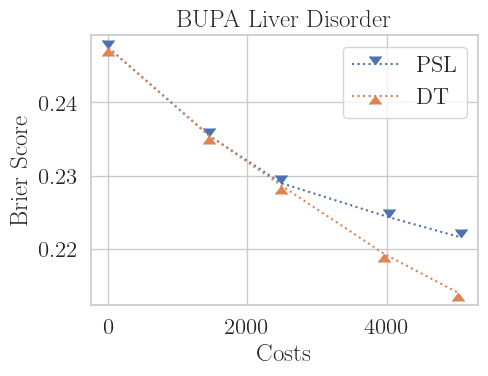

In [20]:
briers_psl_bupa, briers_dt_bupa, accs_psl_bupa, accs_dt_bupa, baccs_psl_bupa, baccs_dt_bupa, costs_psl_bupa, costs_dt_bupa = evaluate_insample("bupa")

plt.figure(figsize=(5,3.5))
plt.plot(costs_psl_bupa, briers_psl_bupa, label="PSL", marker=7, ls=":", markersize=8)
plt.plot(costs_dt_bupa, briers_dt_bupa, label="DT", marker=6, ls=":", markersize=8)

plt.xlabel("Costs")
plt.ylabel("Brier Score")

plt.legend()
plt.title("BUPA Liver Disorder")
plt.savefig("brier_psl_dt_bupa.pdf")
plt.show()

0 [3488.  191.]
0.04922098130327054
1 [3488.  191.]
0.015190319430602117
2 [3488.  191.]
0.006008828888687546
3 [3488.  191.]
0.003780311766863621
4 [3488.  191.]
0.003419582810897071
5 [3488.  191.]
0.003419582810897071
6 [3488.  191.]
0.003419582810897071
7 [3488.  191.]
0.003419582810897071
8 [3488.  191.]
0.003419582810897071
9 [3488.82795699  190.17204301]
0.003414460193507343
10 [3489.78494624  189.21505376]
0.003427895278992671
11 [3491.94117647  187.05882353]
0.0034583265536840065
12 [3492.57292773  186.42707227]
0.003717566962141889
13 [3493.15543478  185.84456522]
0.004057511730606092
14 [3497.48872159  181.51127841]
0.004237755254814823
15 [3500.17505708  178.82494292]
0.004389437440367021
16 [3502.82281501  176.17718499]
0.005465047470316489
17 [3507.29631326  171.70368674]
0.006675178379298827
18 [3509.18382353  169.81617647]
0.006501911978676318
19 [3514.42620048  164.57379952]
0.006164310869010526


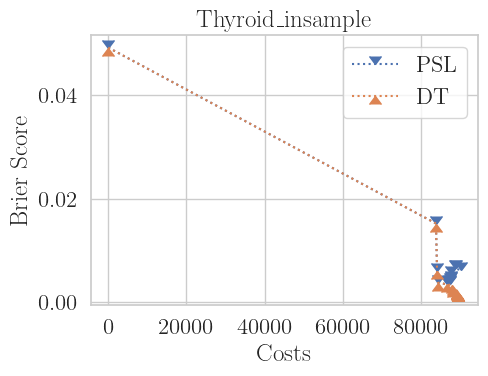

In [21]:
briers_psl_thyroid, briers_dt_thyroid, accs_psl_thyroid, accs_dt_thyroid, baccs_psl_thyroid, baccs_dt_thyroid, costs_psl_thyroid, costs_dt_thyroid = evaluate_insample("thyroid")

plt.figure(figsize=(5,3.5))
plt.plot(costs_psl_thyroid, briers_psl_thyroid, label="PSL", marker=7, ls=":", markersize=8)
plt.plot(costs_dt_thyroid, briers_dt_thyroid, label="DT", marker=6, ls=":", markersize=8)

plt.xlabel("Costs")
plt.ylabel("Brier Score")

plt.legend()
plt.title("Thyroid_insample")
plt.savefig("brier_psl_dt_thyroid.pdf")
plt.show()

[Text(0.4659090909090909, 0.9166666666666666, 'x[3] <= 0.5\nentropy = 0.993\nsamples = 200\nvalue = [90.0, 110.0]'),
 Text(0.25, 0.75, 'x[1] <= 0.5\nentropy = 1.0\nsamples = 169\nvalue = [84, 85]'),
 Text(0.3579545454545454, 0.8333333333333333, 'True  '),
 Text(0.13636363636363635, 0.5833333333333334, 'x[0] <= 0.5\nentropy = 0.877\nsamples = 27\nvalue = [8, 19]'),
 Text(0.09090909090909091, 0.4166666666666667, 'x[4] <= 0.5\nentropy = 0.918\nsamples = 24\nvalue = [8, 16]'),
 Text(0.045454545454545456, 0.25, 'entropy = 0.9\nsamples = 19\nvalue = [6, 13]'),
 Text(0.13636363636363635, 0.25, 'entropy = 0.971\nsamples = 5\nvalue = [2, 3]'),
 Text(0.18181818181818182, 0.4166666666666667, 'entropy = 0.0\nsamples = 3\nvalue = [0, 3]'),
 Text(0.36363636363636365, 0.5833333333333334, 'x[4] <= 0.5\nentropy = 0.996\nsamples = 142\nvalue = [76, 66]'),
 Text(0.2727272727272727, 0.4166666666666667, 'x[2] <= 0.5\nentropy = 0.981\nsamples = 105\nvalue = [61.0, 44.0]'),
 Text(0.22727272727272727, 0.25, '

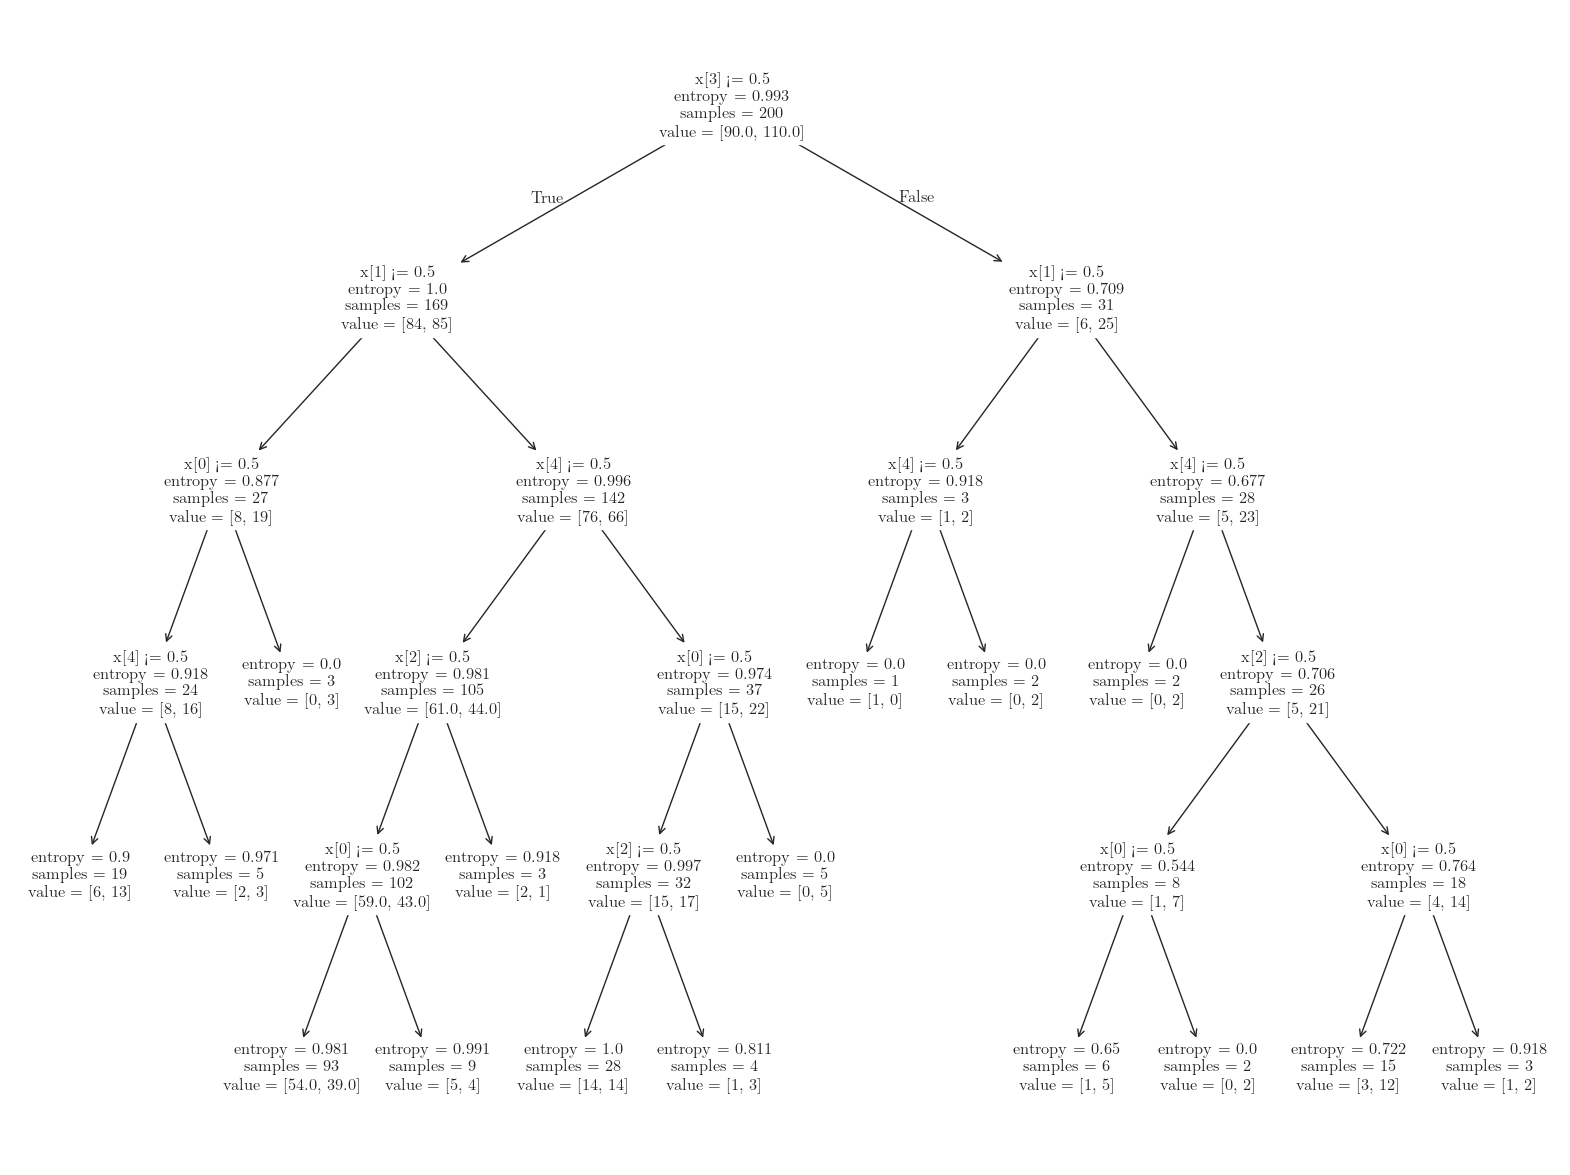

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
plot_tree(dt_bupa)

In [23]:
print(np.unique(pre_bupa.transform(X_train_bupa)))
print(np.unique(X_test_bupa))
print(np.unique(pre_thyroid.transform(X_train_thyroid)))
print(np.unique(X_test_thyroid))
print(np.unique(y_train_bupa))
print(np.unique(y_test_bupa))
print(np.unique(y_train_thyroid))
print(np.unique(y_test_thyroid))

[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]


In [24]:
pareto_x

[0.0,
 76426.89999999714,
 76701.89999999714,
 76916.89999999714,
 79312.99999999757,
 79535.99999999757,
 79749.99999999756,
 79819.99999999757,
 999999999]

In [38]:
x1 = np.array([0,0,1,1])
x2 = np.array([0,1,0,1])
y = np.logical_xor(x1,x2).astype(int)
dt_xor = DecisionTreeClassifier(criterion="entropy")
dt_xor.fit(np.vstack([x1,x2]).T,y)

DecisionTreeClassifier(criterion='entropy')

[Text(0.5, 0.8333333333333334, 'x[0] <= 0.5\nentropy = 1.0\nsamples = 4\nvalue = [2, 2]'),
 Text(0.25, 0.5, 'x[1] <= 0.5\nentropy = 1.0\nsamples = 2\nvalue = [1, 1]'),
 Text(0.375, 0.6666666666666667, 'True  '),
 Text(0.125, 0.16666666666666666, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.375, 0.16666666666666666, 'entropy = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.75, 0.5, 'x[1] <= 0.5\nentropy = 1.0\nsamples = 2\nvalue = [1, 1]'),
 Text(0.625, 0.6666666666666667, '  False'),
 Text(0.625, 0.16666666666666666, 'entropy = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.875, 0.16666666666666666, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0]')]

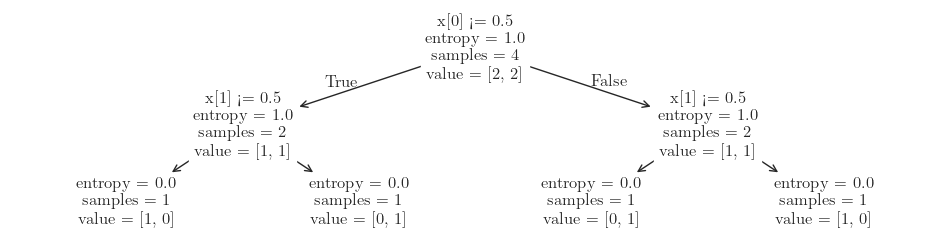

In [39]:
plot_tree(dt_xor)